In [1]:
# INIT

import ipaddress
import json
import pandas as pd
import matplotlib.pyplot as plt
from collections import defaultdict
from datetime import datetime, timedelta
import numpy as np
from pathlib import Path
from collections import Counter
import ast
import matplotlib.colors as mcolors
import maxminddb
from itertools import combinations

def ip_to_subnet(ip):
   try:
       return str(ipaddress.IPv4Network(f"{ip}/24", strict=False).network_address) + "/24"
   except:
       return None

def ip_to_asn(ip_address, db_path='data/external/GeoLite2-ASN.mmdb'):
    try:
        with maxminddb.open_database(db_path) as reader:
            result = reader.get(ip_address)
            return result['autonomous_system_organization']
    except Exception as e:
        return None
   
def set_plt_latex_format():
    plt.rcParams.update({
        "font.size": 12,          # Base font size
        "axes.titlesize": 12,     # Title size
        "axes.labelsize": 10,     # Axis label size
        "xtick.labelsize": 10,    # X-tick label size
        "ytick.labelsize": 10,    # Y-tick label size
        "legend.fontsize": 12,    # Legend font size
        "figure.titlesize": 12,    # Figure title size
        "text.usetex": True,
        "font.family": "serif",
        "font.serif": ["Computer Modern Roman"]
    })

def retrieve_color_palette(n_colors=10, blends=None):
    if blends is None or len(blends) < 2:
        blends = ['#c40d1e', '#9013fe']  # Default red to purple
    
    # Convert all hex colors to RGB
    rgb_colors = [np.array(mcolors.hex2color(color)) for color in blends]
    
    # Calculate how many segments we need
    segments = len(blends) - 1
    colors_per_segment = n_colors // segments
    extra_colors = n_colors % segments  # Distribute remainder colors among segments
    
    # Create the color list
    colors = []
    
    for i in range(segments):
        start_color = rgb_colors[i]
        end_color = rgb_colors[i+1]
        
        # Calculate how many colors for this segment (distribute remainder)
        segment_colors = colors_per_segment + (1 if i < extra_colors else 0)
        
        # Create colors for this segment
        for j in range(segment_colors):
            if segment_colors > 1:  # Avoid division by zero
                t = j / (segment_colors - 1)
            else:
                t = 0
            color = tuple(start_color + (end_color - start_color) * t)
            colors.append(color)
    
    # Create matplotlib colormap and seaborn palette
    custom_cmap = mcolors.ListedColormap(colors)
    #custom_palette = sns.color_palette(colors, n_colors=len(colors))
    
    return colors, custom_cmap#, custom_palette

servers = {}
with open('.env', 'r') as f:
    for line in f:
        if '=' in line:
            key, value = line.strip().split('=', 1)
            servers[key] = value

In [2]:
def load_json(folder_path):
    # load all jsons
    all_packets = []
    all_peers = []

    for json_file in folder_path.glob("*.json"):
       with open(json_file, 'r') as f:
           data = json.load(f)
    
       for packet in data['packets']:
            packet_meta = {k: v for k, v in packet.items() if not k in ['local_peerlist_new', 'node_data', 'payload_data']}

            if not packet['node_data'] is None:
                for k, v in packet['node_data'].items():
                    packet_meta[k] = v
            if not packet['payload_data'] is None:
                for k, v in packet['payload_data'].items(): 
                    packet_meta[k] = v

            if not packet['local_peerlist_new'] is None:
                packet['peerlist_length'] = len(packet['local_peerlist_new'])
                for peer in packet['local_peerlist_new']:
                    peer_data = peer.copy()
                    peer_data['source_ip'] = packet['source_ip']
                    peer_data['timestamp'] = packet['timestamp']
                    peer_data['pl_identifier'] = packet['timestamp'] + '_' + packet['source_ip']
                    all_peers.append(peer_data)

            all_packets.append(packet_meta)

    return pd.DataFrame(all_packets), pd.DataFrame(all_peers)

folder_path=Path("data/packets/ams")
node = str.split(str(folder_path), '/')[-1]
my_ip = servers[node]
default_port = 18080

peer_packets_df, peers_df = load_json(folder_path=folder_path)
# some data cleaning
possible_flags = ['1', '2', '1,2', '2,1', '1,1']
peer_packets_df = peer_packets_df[peer_packets_df['monero_flags'].isin(possible_flags)]
peer_packets_df['timestamp'] = pd.to_datetime(peer_packets_df['timestamp'])


In [3]:
def create_result_df(peer_packets_df):
    grouped = peer_packets_df.groupby('source_ip')

    result_df = pd.DataFrame()

    result_df['source_ip'] = grouped['source_ip'].first()
    result_df['packet_count'] = grouped.size()
    result_df['unique_commands'] = grouped['command'].nunique()
    result_df['my_ports'] = grouped['my_port'].apply(lambda x: x.dropna().astype(int).unique().tolist())
    result_df['unique_my_ports'] = grouped['my_port'].nunique()
    result_df['rpc_ports'] = grouped['rpc_port'].apply(lambda x: x.dropna().astype(int).unique().tolist())
    result_df['unique_rpc_ports'] = grouped['rpc_port'].nunique()
    result_df['peer_ids'] = grouped['peer_id'].apply(lambda x: x.dropna().unique().tolist())
    result_df['unique_peer_ids'] = grouped['peer_id'].nunique()
    result_df['has_support_flags'] = grouped['support_flags'].apply(lambda x: x.notna().any())
    result_df['unique_source_ports'] = grouped['source_port'].nunique()

    return pd.DataFrame(result_df)

result_df = create_result_df(peer_packets_df)
quantiles = [0.5, 0.75, 0.9, 0.99]
stats = ['packet_count', 'unique_my_ports', 'unique_peer_ids', 'unique_source_ports', 'unique_rpc_ports']
#print(result_df.head())
print("-"*50)
print(f"Basic stats based on IP")
print("-"*50)
for s in stats:
    print('-'*50)
    print(f"Distribution for {s}")
    print('-'*50)
    for q in quantiles:
        print(f"{q}th: {result_df[s].quantile(q)}")
    print(f"Max: {result_df[s].max()}")

# quick check grouped by peer_id, only relevant for exploration
def create_peer_id_df(peer_packets_df):
    grouped = peer_packets_df.groupby('peer_id')

    result_df = pd.DataFrame()

    result_df['peer_id'] = grouped['peer_id'].first()

    result_df['source_ips'] = grouped['source_ip'].apply(lambda x: x.dropna().unique().tolist())
    result_df['unique_source_ips'] = grouped['source_ip'].nunique()

    return pd.DataFrame(result_df)

peer_id_df = create_peer_id_df(peer_packets_df)
quantiles = [0.5, 0.75, 0.9, 0.999]
stats = ['unique_source_ips']
print("-"*50)
print(f"Basic stats based on Peer ID")
print("-"*50)
for s in stats:
    print('-'*50)
    print(f"Percentile distribution for {s}")
    print('-'*50)
    for q in quantiles:
        print(f"{q}th: {peer_id_df[s].quantile(q)}")
    print(f"Max: {peer_id_df['unique_source_ips'].max()}")

--------------------------------------------------
Basic stats based on IP
--------------------------------------------------
--------------------------------------------------
Distribution for packet_count
--------------------------------------------------
0.5th: 25.0
0.75th: 207.0
0.9th: 488.40000000000055
0.99th: 4753.079999999999
Max: 2669659
--------------------------------------------------
Distribution for unique_my_ports
--------------------------------------------------
0.5th: 1.0
0.75th: 1.0
0.9th: 1.0
0.99th: 3.0
Max: 125
--------------------------------------------------
Distribution for unique_peer_ids
--------------------------------------------------
0.5th: 1.0
0.75th: 1.0
0.9th: 1.0
0.99th: 5.0
Max: 21252
--------------------------------------------------
Distribution for unique_source_ports
--------------------------------------------------
0.5th: 1.0
0.75th: 2.0
0.9th: 3.0
0.99th: 13.0
Max: 18071
--------------------------------------------------
Distribution for uniq

In [4]:
# quick clustering to find shared peer ids among distinct IPs 
def add_peer_id_clusters(result_df, node):
   from collections import defaultdict
   
   # Build graph of connections
   graph = defaultdict(set)
   for _, row in result_df.iterrows():
       ip = row['source_ip']
       for peer_id in row['peer_ids']:
           graph[ip].add(peer_id)
           graph[peer_id].add(ip)
   
   # Find connected components using stack
   visited = set()
   clusters = []
   
   for start_node in graph:
       if start_node in visited:
           continue
           
       cluster = set()
       stack = [start_node]
       
       while stack:
           current_node = stack.pop()
           if node in visited:
               continue
           visited.add(current_node)
           cluster.add(current_node)
           stack.extend(graph[current_node] - visited)
       
       clusters.append(cluster)
   
   # Map IPs to cluster IDs
   ip_to_cluster = {}
   for i, cluster in enumerate(clusters):
       for current_node in cluster:
           if current_node in result_df['source_ip'].values:
               ip_to_cluster[current_node] = i
   
   # Add cluster column
   result_df = result_df.copy()
   result_df[f'peer_id_cluster_{node}'] = result_df['source_ip'].map(ip_to_cluster)
   return result_df

result_df = add_peer_id_clusters(result_df, node)

In [5]:
#print(peer_packets_df.head(1))
for _, row in peer_packets_df.iterrows():
    if row['source_ip'] == '164.92.217.0':
        print(row) 
        break

source_ip                                    164.92.217.0
source_port                                         36706
dst_ip                                       37.27.70.253
dst_port                                            18080
timestamp                      2025-06-02 12:46:41.486839
command                                              2002
monero_flags                                            1
tcp_segments                                           30
tcp_length                                            995
cumulative_difficulty                                 NaN
cumulative_difficulty_top64                           NaN
current_height                                        NaN
top_id                                                NaN
top_version                                           NaN
pruning_seed                                          NaN
local_time                                            NaN
my_port                                               NaN
network_id    

In [6]:
def get_connection_info(row):
    # Determine if outgoing (my_ip uses ephemeral port) or incoming (peer uses ephemeral port)
    if row['source_ip'] == my_ip and row['source_port'] != default_port:
        # Outgoing: my port is ephemeral
        return 'outgoing', row['dst_ip'], f"{my_ip}:{row['source_port']}->{row['dst_ip']}:{row['dst_port']}"
    elif row['source_ip'] != my_ip and row['dst_port'] != default_port:
        # Outgoing: peer is responding, but connection was initiated by me
        return 'outgoing', row['source_ip'], f"{my_ip}:{row['dst_port']}->{row['source_ip']}:{row['source_port']}"
    elif row['source_ip'] == my_ip and row['source_port'] == default_port:
        # Incoming: my port is default
        return 'incoming', row['source_ip'], f"{my_ip}:{default_port}<-{row['dst_ip']}:{row['dst_port']}"
    elif row['source_ip'] != my_ip and row['dst_port'] == default_port:
        # Incoming: I'm responding, but connection was initiated by peer
        return 'incoming', row['dst_ip'], f"{my_ip}:{default_port}<-{row['source_ip']}:{row['source_port']}"
    
def group_per_connection(peer_packets_df):
   all_data = peer_packets_df.copy()
   connection_info = all_data.apply(get_connection_info, axis=1)
   all_data['direction'] = [info[0] for info in connection_info]
   all_data['peer_ip'] = [info[1] for info in connection_info]
   all_data['connection_key'] = [info[2] for info in connection_info]
   
   # Sort by connection and timestamp
   all_data = all_data.sort_values(['connection_key', 'timestamp'])
   all_data['connection_key_cat'] = all_data['connection_key'].astype('category')
   all_data['prev_connection'] = all_data['connection_key_cat'].shift(1)
   all_data['time_diff'] = all_data['timestamp'].diff().dt.total_seconds()
   
   # Identify connection breaks
   all_data['is_break'] = (
       (all_data['connection_key_cat'] != all_data['prev_connection']) |
       (all_data['time_diff'] > 120) |
       (all_data['time_diff'].isna())
   )
   all_data['connection_id'] = all_data['is_break'].cumsum()
   grouped = all_data.groupby('connection_id')
   
   # initial conn_df with basic info
   valid_conn_ids = grouped.size()[grouped.size() >= 2].index
   conn_info = []
   
   for conn_id in valid_conn_ids:
       conn = grouped.get_group(conn_id)
       source_ip = conn['source_ip'].iloc[0]
       timestamps = np.array(conn['timestamp'])
       duration = timestamps[-1] - timestamps[0]
       
       conn_info.append({
           'connection_id': conn_id,
           'source_ip': source_ip, 
           'duration': duration,
           'ts_latency': None,
           'total_pings': None,
           'ping_frequency': None
       })
   
   conn_df = pd.DataFrame(conn_info)
   return grouped, conn_df

grouped, conn_df = group_per_connection(peer_packets_df)

In [7]:
def analyze_ts_latency(grouped, conn_df, my_ip):
   all_ts_diffs = []
   my_ts_diffs = []
   
   for idx, row in conn_df.iterrows():
       conn_id = row['connection_id']
       conn = grouped.get_group(conn_id)
       
       commands = np.array(conn['command'])
       monero_flags = np.array(conn['monero_flags'])
       timestamps = np.array(conn['timestamp'])
       source_ips = np.array(conn['source_ip'])
       
       # peer TS requests
       ts_mask = (commands == '1002') & (monero_flags == '1') & (source_ips != my_ip)
       ts_series = pd.Series(timestamps[ts_mask])
       
       if len(ts_series) > 2:
           differences = ts_series.diff().dt.total_seconds().dropna()
           all_ts_diffs.extend(differences)
           latency = differences.mean()
           conn_df.loc[idx, 'ts_latency'] = latency
       
       # mine for reference but less details needed
       ts_mask = (commands == '1002') & (monero_flags == '1') & (source_ips == my_ip)
       ts_series = pd.Series(timestamps[ts_mask])
       if len(ts_series) > 2:
           differences = ts_series.diff().dt.total_seconds().dropna()
           my_ts_diffs.extend(differences)
   
   print(f"My TS latency: {np.mean(my_ts_diffs)}")
   print(f"Other TS latency: {np.mean(all_ts_diffs)}")

   return conn_df

conn_df = analyze_ts_latency(grouped, conn_df, my_ip=my_ip)

My TS latency: 62.65017365674862
Other TS latency: 79.61079654214298


--------------------------------------------------
Connection's Avg Timed Sync Frequency Analysis:
--------------------------------------------------
41611 individual connections: 95.0081177253839
Max: 10804.9390075
Percentile distribution: 
    0.5th percentile: 62.171883727272736
    0.75th percentile: 63.880661999999994
    0.9th percentile: 95.55165439632547
    0.99th percentile: 823.6142700858635


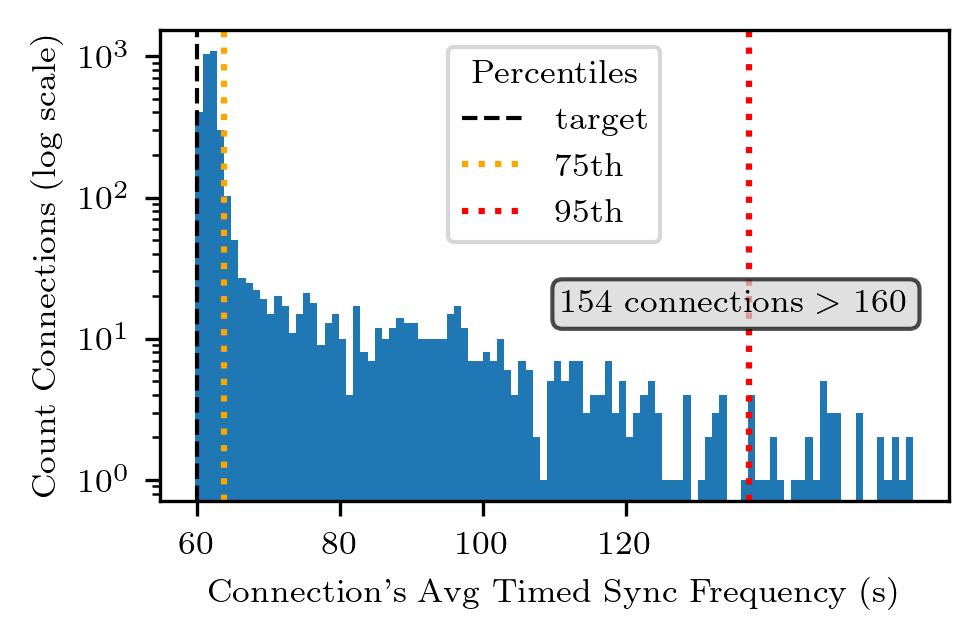

In [8]:
def plot_ts_latency(conn_df):
    quantiles = [0.5, 0.75, 0.9, 0.99]
    print(f"-"*50)
    print(f"Connection\'s Avg Timed Sync Frequency Analysis:")
    print(f"-"*50)
    print(f"{len(conn_df['ts_latency'])} individual connections: {np.mean(conn_df['ts_latency'])}")
    print(f"Max: {conn_df['ts_latency'].max()}")
    print(f"Percentile distribution: ")
    for quantile in quantiles:
        print(f"    {quantile}th percentile: {conn_df['ts_latency'].quantile(quantile)}")
    set_plt_latex_format()
    plt.figure(figsize=(3.13, 2), dpi=300)
    limit = 160
    plt.hist(conn_df['ts_latency'].dropna(), range=(conn_df['ts_latency'].min(), limit), bins=int(limit-conn_df['ts_latency'].min()), log=True)
    #plt.axvline(result_df['ts_latency'].quantile(0.5), color='orange', linestyle='--', label='50th')
    plt.axvline(60, color='black', linestyle='--', label='target', linewidth=1)
    plt.axvline(conn_df['ts_latency'].quantile(0.75), color='orange', linestyle=':', label='75th')
    plt.axvline(conn_df['ts_latency'].quantile(0.95), color='red', linestyle=':', label='95th')
    outlier_count = sum(x > limit for x in conn_df['ts_latency'].dropna())
    plt.text(0.95, 0.45, f'{outlier_count} connections $>$ {limit}', fontsize=8,
             transform=plt.gca().transAxes, ha='right', va='top',
             bbox=dict(boxstyle='round,pad=0.3', facecolor='lightgray', alpha=0.7))
    plt.xlabel(f'Connection\'s Avg Timed Sync Frequency (s)', fontsize=8)
    plt.xticks([60,80,100,120], fontsize=8)
    plt.yticks(fontsize=8)
    plt.ylabel(f'Count Connections (log scale)', fontsize=8)
    plt.legend(title='Percentiles', fontsize=8, title_fontsize=8)
    plt.tight_layout(pad=0.2)
    #plt.savefig('results/graphs/ts_latency_dist.pdf')
    plt.show()

plot_ts_latency(conn_df)


Ping Analysis:
41611 connections.
Percentile distribution of number of Pings sent per connection: 
    0.5th percentile: 23.0
    0.75th percentile: 24.0
    0.9th percentile: 25.0
    0.95th percentile: 26.0
    0.99th percentile: 27.0
Percentile distribution of frequency of Pings if more than one is sent: 
    0.5th percentile: 7.254878863636365
    0.75th percentile: 7.574055904761904
    0.9th percentile: 7.955081838095238
    0.95th percentile: 8.329177039999996
    0.99th percentile: 8.745350582315789
0


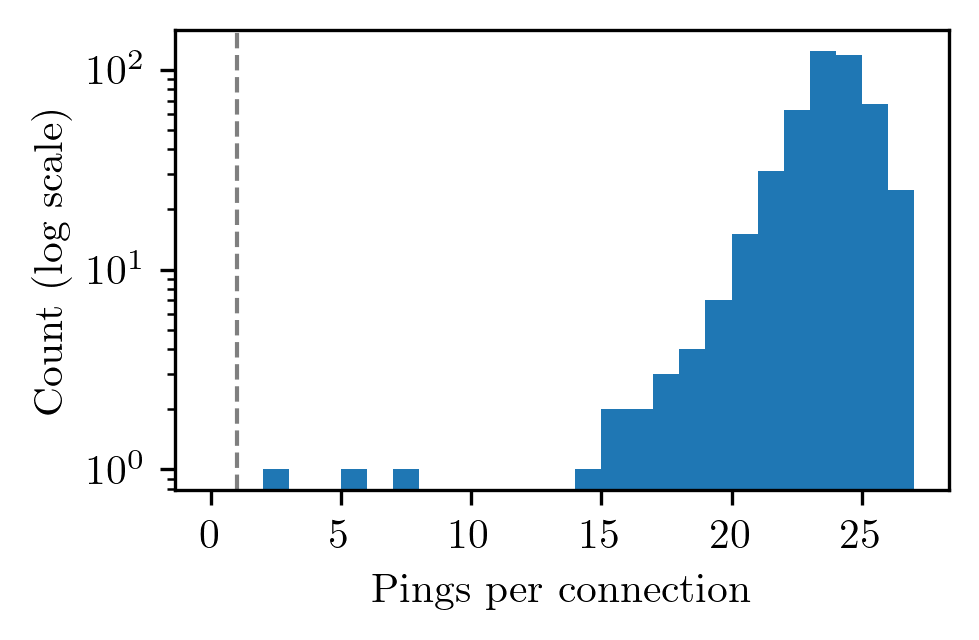

In [9]:
def analyze_ping_flooding(grouped, conn_df, my_ip):
   for idx, row in conn_df.iterrows():
       conn_id = row['connection_id']
       conn = grouped.get_group(conn_id)
       
       commands = np.array(conn['command'])
       monero_flags = np.array(conn['monero_flags'])
       timestamps = np.array(conn['timestamp'])
       source_ips = np.array(conn['source_ip'])
       
       ping_req_mask = (commands == '1003') & (source_ips != my_ip) & (monero_flags == '1')
       ping_req_series = pd.Series(timestamps[ping_req_mask])
       ping_resp_mask = (commands == '1003') & (source_ips == my_ip) & (monero_flags == '2')
       ping_resp_series = pd.Series(timestamps[ping_resp_mask])
       
       # does the peer send pings more often although I responded
       if len(ping_req_series) > 1 and commands[0] == '1001' and len(ping_resp_series) > 0:
           # did I respond before he initiated another ping to avoid issues with my node
           if ping_resp_series.iloc[0] < ping_resp_series.iloc[-1]:
               ping_differences = ping_req_series.diff().dt.total_seconds().dropna()
               total_pings = len(ping_req_series)
               ping_frequency = ping_differences.mean()
               
               conn_df.loc[idx, 'total_pings'] = total_pings
               conn_df.loc[idx, 'ping_frequency'] = ping_frequency
   
   return conn_df
                
conn_df = analyze_ping_flooding(grouped=grouped, conn_df=conn_df, my_ip=my_ip)

def plot_ping_flooding(conn_df):
    # Ping Plots
    quantiles = [0.50, 0.75, 0.90, 0.95, 0.99]
    print(f"\nPing Analysis:")
    print(f"{len(conn_df['total_pings'])} connections.")
    print(f"Percentile distribution of number of Pings sent per connection: ")
    for quantile in quantiles:
        print(f"    {quantile}th percentile: {conn_df['total_pings'].quantile(quantile)}")
    print(f"Percentile distribution of frequency of Pings if more than one is sent: ")
    for quantile in quantiles:
        print(f"    {quantile}th percentile: {conn_df['ping_frequency'].quantile(quantile)}")
    
    plt.figure(figsize=(3.13, 2), dpi=300)
    plt.hist(conn_df['total_pings'].dropna(), bins=conn_df['total_pings'].max(), range=(0, conn_df['total_pings'].max()), log=True)
    #plt.xlim(0, 35)
    plt.axvline(1, color='black', linestyle='--', linewidth=1, alpha=0.5, label='default')
    #plt.text(1.05, plt.ylim()[1]*0.9, 'default: 1', verticalalignment='top', fontsize=10)
    #plt.axvline(result_df['total_pings'].quantile(0.9), color='orange', linestyle=':', label='90th')
    #plt.axvline(result_df['total_pings'].quantile(0.95), color='red', linestyle=':', label='95th')

    outlier_count = sum(x > 35 for x in conn_df['total_pings'].dropna())
    print(outlier_count)
    plt.xlabel(f'Pings per connection')
    plt.ylabel(f'Count (log scale)')
    #plt.legend(title='Percentiles', fontsize=10, title_fontsize=10)
    plt.tight_layout(pad=0.2)
    plt.show()

plot_ping_flooding(conn_df)

In [ ]:
def get_command_category(cmd, flag):
    """Map commands and flags to categories"""
    category_map = {
        ('1001', '1'): 1,    # Handshake Request
        ('1001', '2'): 5,
        ('1002', '1'): 2,    # Timed Sync Request
        ('1002', '2'): 3,    # Timed Sync Response
        ('1003', '1'): 4,            # Ping
        ('1003', '2'): 6
    }
    
    return category_map.get((cmd, flag), 0)

def setup_axis_appearance(ax, time_duration_seconds, show_ylabel=True):
    """Configure axis appearance for LaTeX paper"""
    #category_labels = ['Handshake', 'TS Request', 'TS Response', 'Ping']
    category_labels = ['HS Req', 'TS Req', 'TS Resp', 'Ping', 'HS Resp', 'Pong']
    

    ax.set_xlabel('Time (s)', fontsize=10)
    ax.set_yticklabels(category_labels if show_ylabel else ['', '', '', ''], fontsize=10)
    ax.tick_params(axis='both', which='major', labelsize=10)
    ax.set_yticks([1, 2, 3, 4, 5, 6])
    ax.set_ylim(0.5, 4.5)
    ax.set_xlim(0, time_duration_seconds)
    ax.grid(True, alpha=0.3, linestyle='--')

def plot_command_timeline_subplot(ax, base_commands, base_flags, base_series, title, 
                                time_duration_seconds=300, show_ylabel=True):
    """Plot command timeline on given axis"""
    
    if len(base_series) == 0:
        ax.text(0.5, 0.5, 'No data', transform=ax.transAxes, 
                ha='center', va='center', fontsize=7)
        ax.set_title(title, fontsize=8, pad=8)

        setup_axis_appearance(ax, time_duration_seconds, show_ylabel)
        return
    
    # Convert to seconds from start and filter by duration
    time_seconds = (base_series - base_series.iloc[0]).dt.total_seconds()
    time_mask = time_seconds <= time_duration_seconds
    
    if not time_mask.any():
        ax.text(0.5, 0.5, 'No data in time range', transform=ax.transAxes, 
                ha='center', va='center', fontsize=9)
        ax.set_title(title, fontsize=10, pad=10)
        setup_axis_appearance(ax, time_duration_seconds, show_ylabel)
        return
    
    # Filter data and create categories
    commands_filtered = base_commands[time_mask]
    flags_filtered = base_flags[time_mask]
    time_filtered = time_seconds[time_mask]
    
    categories = [get_command_category(cmd, flag) 
                  for cmd, flag in zip(commands_filtered, flags_filtered)]
    
    # Plot with improved styling
    ax.plot(time_filtered, categories, marker='o', linewidth=1.2, markersize=3,
            color='#2E86C1', markerfacecolor='#2E86C1', markeredgecolor='white', 
            markeredgewidth=0.5)
    
    ax.set_title(title, fontsize=10, pad=10, weight='bold')
    setup_axis_appearance(ax, time_duration_seconds, show_ylabel)



In [18]:
def get_connection_info(row):
    # Determine if outgoing (my_ip uses ephemeral port) or incoming (peer uses ephemeral port)
    if row['source_ip'] == my_ip and row['source_port'] != default_port:
        # Outgoing: my port is ephemeral
        return 'outgoing', row['dst_ip'], f"{my_ip}:{row['source_port']}->{row['dst_ip']}:{row['dst_port']}"
    elif row['source_ip'] != my_ip and row['dst_port'] != default_port:
        # Outgoing: peer is responding, but connection was initiated by me
        return 'outgoing', row['source_ip'], f"{my_ip}:{row['dst_port']}->{row['source_ip']}:{row['source_port']}"
    elif row['source_ip'] == my_ip and row['source_port'] == default_port:
        # Incoming: my port is default
        return 'incoming', row['source_ip'], f"{my_ip}:{default_port}<-{row['dst_ip']}:{row['dst_port']}"
    elif row['source_ip'] != my_ip and row['dst_port'] == default_port:
        # Incoming: I'm responding, but connection was initiated by peer
        return 'incoming', row['dst_ip'], f"{my_ip}:{default_port}<-{row['source_ip']}:{row['source_port']}"
    
# build connections dataframe 
df_indexed = result_df.set_index('source_ip')

ts_latency_lower = conn_df['ts_latency'].quantile(0.75)
ts_latency_upper = conn_df['ts_latency'].quantile(0.95)
print(ts_latency_lower)
print(ts_latency_upper)

63.880661999999994
137.1259324094805


/tmp/ipykernel_52649/1448074679.py:21: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(category_labels if show_ylabel else ['', '', '', ''], fontsize=10)
/tmp/ipykernel_52649/1448074679.py:21: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(category_labels if show_ylabel else ['', '', '', ''], fontsize=10)
/tmp/ipykernel_52649/1448074679.py:21: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(category_labels if show_ylabel else ['', '', '', ''], fontsize=10)


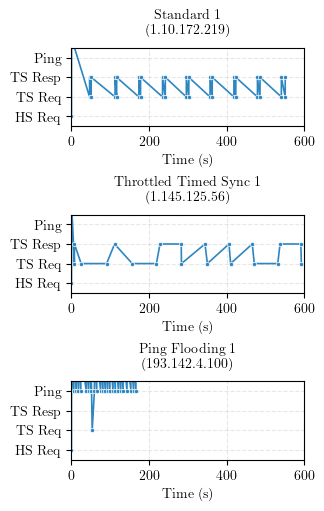

In [47]:
def classify_connection(conn_row, duration_m, commands, ts_latency_lower, ts_latency_upper, 
                       min_duration_minutes):
    """Classify connection type based on characteristics"""
    
    if commands[0] != '1001':  # Must start with handshake
        return None
    
    if conn_row['ping_frequency'] == None: 
        conn_row['ping_frequency'] = 0
    if conn_row['ts_latency'] == None:
        conn_row['ts_latency'] = 6000

    conditions = {
        'standard': (
            (conn_row['ts_latency'] < ts_latency_lower) &
            (conn_row['ping_frequency'] == 0) & 
            (duration_m > timedelta(minutes=min_duration_minutes))
        ),
        'nonstandard': (
            (conn_row['ts_latency'] > ts_latency_upper) &
            (duration_m > timedelta(minutes=min_duration_minutes))
        ),
        'ping': (
            (conn_row['ping_frequency'] > 0) & 
            (conn_row['ping_frequency'] < 10)
        )
    }

    for conn_type, condition in conditions.items():
        
        if condition:
            return conn_type
    return None

connection_data = {conn_type: [] for conn_type in ['standard', 'nonstandard', 'ping']}
type_counts = {conn_type: 0 for conn_type in connection_data.keys()}

max_connections_per_type=1
min_duration_minutes=8
min_ping_commands=3
time_duration_seconds=600

for idx, row in conn_df.iterrows():
    conn_id = row['connection_id']
    conn = grouped.get_group(conn_id)
    
    commands = np.array(conn['command'])
    monero_flags = np.array(conn['monero_flags'])
    timestamps = np.array(conn['timestamp'])
    source_ips = np.array(conn['source_ip'])

    duration_m=row['duration']


    conn_type = classify_connection(row, duration_m, commands, 
                                      ts_latency_lower, ts_latency_upper, min_duration_minutes)
    
    if (conn_type and type_counts[conn_type] < max_connections_per_type and
            (conn_type != 'ping' or len(commands[commands == '1003']) >= min_ping_commands)):
            
            # Prepare base data for plotting
            base_mask = np.isin(commands, ['1001', '1002', '1003'])
            base_series = pd.Series(timestamps[base_mask])
            
            connection_data[conn_type].append({
                'commands': commands[base_mask],
                'flags': np.array(conn['monero_flags'])[base_mask],
                'series': base_series,
                'source_ip': row['source_ip']
            })
            type_counts[conn_type] += 1

fig, axes = plt.subplots(3, max_connections_per_type, 
                figsize=(3.13*max_connections_per_type, 5),  # Fixed width for half page
                constrained_layout=True)

if max_connections_per_type == 1:
    axes = axes.reshape(-1, 1)

connection_types = ['standard', 'nonstandard', 'ping']
titles = ['Standard', 'Throttled Timed Sync', 'Ping Flooding']

for i, conn_type in enumerate(connection_types):
    for j in range(max_connections_per_type):
        if j < len(connection_data[conn_type]):
            data = connection_data[conn_type][j]
            title = f"{titles[i]} {j+1}\n({data['source_ip']})"
            plot_command_timeline_subplot(
                axes[i, j], data['commands'], data['flags'], 
                data['series'], title, time_duration_seconds, show_ylabel=(j==0)
            )
        else:
            axes[i, j].text(0.5, 0.5, f'No {conn_type}\nconnection {j+1}', 
                           transform=axes[i, j].transAxes, ha='center', va='center',
                           fontsize=9)
            axes[i, j].set_title(f"{conn_type.title()} {j+1}", fontsize=10, pad=10)
            setup_axis_appearance(axes[i, j], time_duration_seconds, show_ylabel=(j==0))

plt.show()